<a href="https://colab.research.google.com/github/isabellacadisco/text-data-for-trading-/blob/main/DistilBert_FinancialNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.6 MB/s eta 0:00:00


In [ ]:
# To finetune transformer model, we need following libraries
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# need DistilBertTokenizer since we are using DistilBert for processig input
# TFDistilBertForSequenceClassification for text classification
# SequenceClassification because we are doing the sentiment analysis so classiy sentences as + or -
# different libraries for different tasks


# To save our trained model, we import pickle library
import pickle

# To pre-process, we need following libraries
import pandas as pd
import numpy as np
import seaborn as sns

# To explre and visualize data, we need following libraries
import matplotlib.pyplot as plt
import plotly.express as px

# To read the data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



carico dataset


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Ammagamma Lab Project/FinancialPhraseBank_AllAgree.txt',sep='\t', encoding = 'latin-1',
               header = None)


In [ ]:
df.loc[0,0]

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral'

In [ ]:
df.head()

,0
0,"According to Gran , the company has no plans t..."
1,"For the last quarter of 2010 , Componenta 's n..."
2,"In the third quarter of 2010 , net sales incre..."
3,Operating profit rose to EUR 13.1 mn from EUR ...
4,"Operating profit totalled EUR 21.1 mn , up fro..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2264 non-null   object
dtypes: object(1)
memory usage: 17.8+ KB


In [ ]:
# Extract the sentiment and text
df[['Text', 'Sentiment']] = df[0].str.split(".@", expand=True)


In [ ]:
df.head()

,0,Text,Sentiment
0,"According to Gran , the company has no plans t...","According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...","For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...","In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...","Operating profit totalled EUR 21.1 mn , up fro...",positive


In [ ]:
# Drop the original column
df.drop(columns=[0], inplace=True)

In [ ]:
df.head()

,Text,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


In [ ]:
df.shape

(2264, 2)

In [ ]:
df['Sentiment'].value_counts()

neutral     1391
positive     570
negative     303
Name: Sentiment, dtype: int64

check if balanced or not

In [ ]:
# Plot count of feedback
df_plot=df.groupby(by=['Sentiment']).size().reset_index(name='count')
px.bar(df_plot,x='Sentiment',y='count')

# Similar plot can be generated using countplot function of seaborn library: sns.countplot(x=df['feedback'])

undersampling

In [ ]:
# Create a dataframe with only negative news
df_negative=df[df['Sentiment']=='negative']

# Create a dataframe with only positive news
df_positive=df[df['Sentiment']=='positive']

# Create a dataframe with only neutral news
df_neutral=df[df['Sentiment']=='neutral']

In [ ]:
df_negative['Text'].iloc[7]

'23 April 2010 - Finnish construction and engineering company Outotec Oyj HEL : OTE1V said today it slipped to a net loss of EUR7 .3 m in the first quarter of 2010 from a net profit of EUR12 .5 m in the corresponding period last year '

In [ ]:
df_positive['Text'].iloc[4]

'Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn '

In [ ]:
df_neutral['Text'].iloc[12]

'It has some 30 offices worldwide and more than 90 pct of its net sales are generated outside Finland '

In [ ]:
# Check number of rows of negative reviews
df_negative.shape[0]

303

In [ ]:
# Down sample
df_positive_downsampled=df_positive.sample(df_negative.shape[0])
df_neutral_downsampled=df_neutral.sample(df_negative.shape[0])
print(df_positive_downsampled.shape, df_neutral_downsampled.shape)

(303, 2) (303, 2)


In [ ]:
# Create a balanced dataset of equal number of positive, neutral and negative reviews
df_balanced=pd.concat([df_positive_downsampled, df_neutral_downsampled, df_negative],axis=0)
df_balanced.shape

(909, 2)

In [ ]:
# Check the review distribution
df_plot=df_balanced.groupby(by=['Sentiment']).size().reset_index(name='count')
px.bar(df_plot,x='Sentiment',y='count')

#sns.countplot(df_balanced['feedback'])

**Check length of reviews**

In [ ]:
df_balanced.head()

,Text,Sentiment
232,Net sales surged by 30 % to EUR 36 million,positive
783,Investors will continue being interested in th...,positive
162,Operating profit rose to EUR 13.5 mn from EUR ...,positive
332,Finnish steel maker Rautaruukki Oyj ( HEL : RT...,positive
740,The brokerage said 2006 has seen a ` true turn...,positive


In [ ]:
df_balanced.iloc[:3, 0].apply(lambda x: print(x.split()))

['Net', 'sales', 'surged', 'by', '30', '%', 'to', 'EUR', '36', 'million']
['Investors', 'will', 'continue', 'being', 'interested', 'in', 'the', 'company', "'s", 'share', 'although', 'it', 'is', 'not', 'quite', 'cheap', ',', 'Affarsvarlden', 'said']
['Operating', 'profit', 'rose', 'to', 'EUR', '13.5', 'mn', 'from', 'EUR', '9.7', 'mn', 'in', 'the', 'corresponding', 'period', 'in', '2006']


232    None
783    None
162    None
Name: Text, dtype: object

In [ ]:
df_balanced['news_length']=df_balanced['Text'].apply(lambda x: len(x.split()))

In [ ]:
df_balanced.head()

,Text,Sentiment,news_length
232,Net sales surged by 30 % to EUR 36 million,positive,10
783,Investors will continue being interested in th...,positive,19
162,Operating profit rose to EUR 13.5 mn from EUR ...,positive,17
332,Finnish steel maker Rautaruukki Oyj ( HEL : RT...,positive,47
740,The brokerage said 2006 has seen a ` true turn...,positive,29


In [ ]:
fig=px.histogram(df_balanced['news_length'],title='News Length')
fig.show()

In [ ]:
# Converting dataframe series object into list
x=df_balanced['Text'].to_list()
x[0:5]

['Net sales surged by 30 % to EUR 36 million ',
 "Investors will continue being interested in the company 's share although it is not quite cheap , Affarsvarlden said ",
 'Operating profit rose to EUR 13.5 mn from EUR 9.7 mn in the corresponding period in 2006 ',
 'Finnish steel maker Rautaruukki Oyj ( HEL : RTRKS ) , or Ruukki , said today its net loss contracted to EUR 49 million ( USD 68.2 m ) for the first nine months of 2010 from EUR 229 million for the same period a year ago ',
 "The brokerage said 2006 has seen a ` true turning point ' in European steel base prices , with better pricing seen carrying through the second quarter of 2006 "]

In [ ]:
df_balanced.head()

,Text,Sentiment,news_length
232,Net sales surged by 30 % to EUR 36 million,positive,10
783,Investors will continue being interested in th...,positive,19
162,Operating profit rose to EUR 13.5 mn from EUR ...,positive,17
332,Finnish steel maker Rautaruukki Oyj ( HEL : RT...,positive,47
740,The brokerage said 2006 has seen a ` true turn...,positive,29


In [ ]:
# Converting dataframe series object into list
y=df_balanced['Sentiment'].to_list()
y[0:5]

['positive', 'positive', 'positive', 'positive', 'positive']

In [ ]:
# LABEL ENCODING
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
# Encode labels as integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)


In [ ]:
# Convert encoded labels to one-hot encoding
one_hot_labels = to_categorical(encoded_labels)


In [ ]:
encoded_labels[0:5]

array([2, 2, 2, 2, 2])

In [ ]:
one_hot_labels [0:5]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
y = encoded_labels.tolist()

In [ ]:
y[0:5]

[2, 2, 2, 2, 2]

a sto punto ho due liste x e y
x: news
y: sentiment

**DistilBert Tokenizer**

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 50 # this is a hyper-parameter

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
def construct_encodings(x, tokenizer, max_len, trucation=True, padding=True):
    return tokenizer(x, max_length=max_len, truncation=trucation, padding=padding)

encodings = construct_encodings(x, tokenizer, max_len=MAX_LEN)

The first stage of preprocessing is done! The second stage is converting our encodings and y (which holds the classes of the reviews) into a Tensorflow Dataset object. Below is a function to do this:

In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

# tokenized data in the form of tensor slices

In [ ]:
tfdataset = construct_tfdataset(encodings, y)

In [ ]:
tfdataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(50,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(50,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
# SPLIT TRAIN TEST

# All these are hyper-parameters
TEST_SPLIT = 0.2
VAL_SPLIT=0.2
BATCH_SIZE = 32

# Initial training size
train_size = int(len(x) * (1-TEST_SPLIT))
val_size=int(len(x) * (VAL_SPLIT))

# At this step, we're only declaring the train & test size
print('Initial Train size is: ',train_size)
print('Test size is: ',int(len(x) * (TEST_SPLIT)))
print('Validation size is: ',val_size)

Initial Train size is:  727
Test size is:  181
Validation size is:  181


In [ ]:
# Shuffling
tfdataset = tfdataset.shuffle(len(x)) # randomly shuffles dataset across dimension of x tensor vector

# Testing data: tfdataset.skip(3) --> will skip inital 3 rows from the dataset. So tfdataset.skip(train_size) will skip initial 411 rows and keep remaining 102 into tfdataset_test
tfdataset_test = tfdataset.skip(train_size)

# Remaining data: tfdataset.take(3) --> will take first 3 rows from the dataset. So tfdataset.take(train_size) will store first 411 rows into tfdataset_rest
tfdataset_rest = tfdataset.take(train_size)

# Now we will split tfdataset_rest into train and validation datasets using val_size=51
tfdataset_train=tfdataset_rest.skip(val_size)
tfdataset_val=tfdataset_rest.take(val_size)

print('Train size is: ',len(tfdataset_train))
print('Test size is: ',len(tfdataset_test))
print('Validation size is: ',len(tfdataset_val))

Train size is:  546
Test size is:  182
Validation size is:  181


In [ ]:
# tfdataset_train.batch creates batches of the data, each batch having number of samples equal to the batch size
tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_val = tfdataset_val.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
print('Number of batches of Training data: ',len(tfdataset_train))
print('Number of batches of Testing data: ',len(tfdataset_test))
print('Number of batches of Validation data: ',len(tfdataset_val))

Number of batches of Training data:  18
Number of batches of Testing data:  6
Number of batches of Validation data:  6


**FINE TUNING MODEL**

In [ ]:
N_EPOCHS = 10 # This is a hyper-parameter
MODEL_NAME = 'distilbert-base-uncased'

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3) # num_labels--> is the number of classes in target class. Here we have 2 classes (2: Positive, Negative e Neutral non so corrispondenza)
optimizer = optimizers.Adam(learning_rate=3e-5) # Learning rate is another hyper-parameter
loss = losses.SparseCategoricalCrossentropy(from_logits=True) # SparseCategoricalCrossentropy is used when our target class is integer encoded.
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS,validation_data=tfdataset_val,verbose=1)

Epoch 1/10
18/18 [==============================] - 35s 453ms/step - loss: 1.0376 - accuracy: 0.4542 - val_loss: 0.8584 - val_accuracy: 0.6851
Epoch 2/10
18/18 [==============================] - 5s 269ms/step - loss: 0.7907 - accuracy: 0.6923 - val_loss: 0.5472 - val_accuracy: 0.8785
Epoch 3/10
18/18 [==============================] - 7s 373ms/step - loss: 0.4354 - accuracy: 0.9029 - val_loss: 0.3906 - val_accuracy: 0.8785
Epoch 4/10
18/18 [==============================] - 5s 250ms/step - loss: 0.2657 - accuracy: 0.9249 - val_loss: 0.1570 - val_accuracy: 0.9613
Epoch 5/10
18/18 [==============================] - 4s 232ms/step - loss: 0.1662 - accuracy: 0.9560 - val_loss: 0.1245 - val_accuracy: 0.9669
Epoch 6/10
18/18 [==============================] - 6s 342ms/step - loss: 0.1221 - accuracy: 0.9725 - val_loss: 0.0655 - val_accuracy: 0.9890
Epoch 7/10
18/18 [==============================] - 4s 230ms/step - loss: 0.0792 - accuracy: 0.9799 - val_loss: 0.0275 - val_accuracy: 1.0000
Epoch

In [ ]:
def plot_metric(history,metric):
    training_metrics=history.history[metric]
    validation_metrics=history.history['val_'+metric]
    epochs=range(1,len(training_metrics)+1)
    plt.plot(epochs,training_metrics)
    plt.plot(epochs,validation_metrics)
    plt.title('Training and Validation '+metric)
    plt.xlabel("Number of Epochs")
    plt.ylabel(metric)
    plt.ylim([0,1.5])
    plt.legend(["training_"+metric, 'validation_'+metric])
    plt.show()

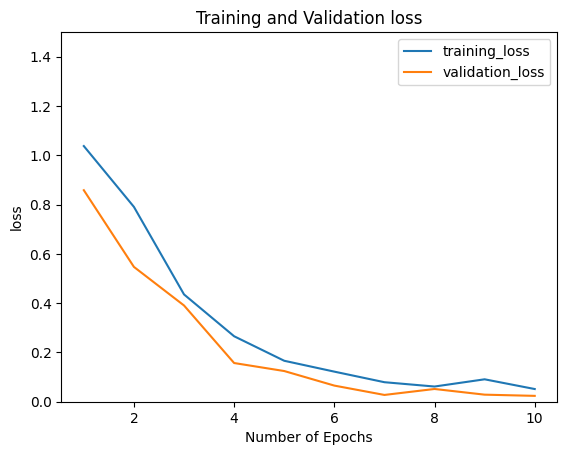

In [ ]:
plot_metric(history, 'loss')

In [ ]:
# Using moedl.evaluate() we test the model performance on unseed data which is stored in tfdataset_test
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE,verbose=1)
print(benchmarks)

6/6 [==============================] - 0s 66ms/step - loss: 0.0150 - accuracy: 1.0000
{'loss': 0.014960302039980888, 'accuracy': 1.0}


In [ ]:
# CREATE PREDICTOR

In [ ]:
# penso che questo predittore che ho creato ritorni la probabilità che
# la news sia neutra

In [ ]:
def create_predictor_negative(model, model_name, max_len):
  tokenizer = DistilBertTokenizer.from_pretrained(model_name)
  def predict_proba(text):
      x = [text]

      encodings = construct_encodings(x, tokenizer, max_len=max_len)
      tfdataset = construct_tfdataset(encodings)
      tfdataset = tfdataset.batch(1)

      preds = model.predict(tfdataset).logits
      print("pred logits: ",preds)
      preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()
      print("softmax o/p: ",preds)
      return preds[0][0]

  return predict_proba


In [ ]:
model

In [ ]:
print(MODEL_NAME, MAX_LEN)

distilbert-base-uncased 50


In [ ]:
clf_negative = create_predictor_negative(model, MODEL_NAME, MAX_LEN)


In [ ]:
print(clf_negative("Huge increase in the US economy")) # POSITIVE: 2
print(clf_negative("Losses are huge in the food market of the US")) # negative: 0
print(clf_negative("US is an exporter of meat")) # NEUTRAL: 1

1/1 [==============================] - 0s 27ms/step
pred logits:  [[-0.9718103 -2.0856242  3.637094 ]]
softmax o/p:  [[0.00983261 0.00322809 0.9869393 ]]
0.009832608
1/1 [==============================] - 0s 29ms/step
pred logits:  [[ 3.2523909 -2.3346624 -1.0894451]]
softmax o/p:  [[0.9835175  0.00368431 0.01279814]]
0.9835175
1/1 [==============================] - 0s 24ms/step
pred logits:  [[-1.9472245  3.1695676 -1.4850761]]
softmax o/p:  [[0.00590364 0.9847244  0.00937192]]
0.005903643


In [ ]:
def create_predictor_positive(model, model_name, max_len):
  tokenizer = DistilBertTokenizer.from_pretrained(model_name)
  def predict_proba(text):
      x = [text]

      encodings = construct_encodings(x, tokenizer, max_len=max_len)
      tfdataset = construct_tfdataset(encodings)
      tfdataset = tfdataset.batch(1)

      preds = model.predict(tfdataset).logits
      print("pred logits: ",preds)
      preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()
      print("softmax o/p: ",preds)
      return preds[0][2]

  return predict_proba

In [ ]:
clf_positive = create_predictor_positive(model, MODEL_NAME, MAX_LEN)

In [ ]:
print(clf_positive("Huge increase in the US economy")) # POSITIVE: 2
print(clf_positive("Losses are huge in the food market of the US")) # negative: 0
print(clf_positive("US is an exporter of meat")) # NEUTRAL: 1

1/1 [==============================] - 0s 27ms/step
pred logits:  [[-0.9718103 -2.0856242  3.637094 ]]
softmax o/p:  [[0.00983261 0.00322809 0.9869393 ]]
0.9869393
1/1 [==============================] - 0s 23ms/step
pred logits:  [[ 3.2523909 -2.3346624 -1.0894451]]
softmax o/p:  [[0.9835175  0.00368431 0.01279814]]
0.012798136
1/1 [==============================] - 0s 23ms/step
pred logits:  [[-1.9472245  3.1695676 -1.4850761]]
softmax o/p:  [[0.00590364 0.9847244  0.00937192]]
0.009371922


In [ ]:
def create_predictor_neutral(model, model_name, max_len):
  tokenizer = DistilBertTokenizer.from_pretrained(model_name)
  def predict_proba(text):
      x = [text]

      encodings = construct_encodings(x, tokenizer, max_len=max_len)
      tfdataset = construct_tfdataset(encodings)
      tfdataset = tfdataset.batch(1)

      preds = model.predict(tfdataset).logits
      print("pred logits: ",preds)
      preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()
      print("softmax o/p: ",preds)
      return preds[0][1]

  return predict_proba

In [ ]:
clf_neutral = create_predictor_neutral(model, MODEL_NAME, MAX_LEN)

In [ ]:
print(clf_neutral("Huge increase in the US economy")) # POSITIVE: 2
print(clf_neutral("Losses are huge in the food market of the US")) # negative: 0
print(clf_neutral("US is an exporter of meat")) # NEUTRAL: 1

1/1 [==============================] - 0s 25ms/step
pred logits:  [[-0.9718103 -2.0856242  3.637094 ]]
softmax o/p:  [[0.00983261 0.00322809 0.9869393 ]]
0.0032280888
1/1 [==============================] - 0s 25ms/step
pred logits:  [[ 3.2523909 -2.3346624 -1.0894451]]
softmax o/p:  [[0.9835175  0.00368431 0.01279814]]
0.003684306
1/1 [==============================] - 0s 23ms/step
pred logits:  [[-1.9472245  3.1695676 -1.4850761]]
softmax o/p:  [[0.00590364 0.9847244  0.00937192]]
0.9847244


In [ ]:
def create_predictor(model, model_name, max_len):
  tokenizer = DistilBertTokenizer.from_pretrained(model_name)
  def predict_proba(text):
      x = [text]

      encodings = construct_encodings(x, tokenizer, max_len=max_len)
      tfdataset = construct_tfdataset(encodings)
      tfdataset = tfdataset.batch(1)

      preds = model.predict(tfdataset).logits
      #print("pred logits: ",preds)
      preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()
      #print("softmax o/p: ",preds)
      return preds[0][0], preds[0][1], preds[0][2]

  return predict_proba


In [ ]:
clf = create_predictor(model, MODEL_NAME, MAX_LEN)

In [ ]:
print(clf("Huge increase in the US economy")) # POSITIVE: 2
print(clf("Losses are huge in the food market of the US")) # negative: 0
print(clf("US is an exporter of meat")) # NEUTRAL: 1

1/1 [==============================] - 0s 54ms/step
(0.009832608, 0.0032280888, 0.9869393)
1/1 [==============================] - 0s 30ms/step
(0.9835175, 0.003684306, 0.012798136)
1/1 [==============================] - 0s 32ms/step
(0.005903643, 0.9847244, 0.009371922)


**saving model for future use**

 saves the trained model and associated information to the disk, allowing you to load them later for inference or further training.

In [ ]:
model.save_pretrained('/content/drive/MyDrive/Ammagamma Lab Project/model/clf')
with open('/content/drive/MyDrive/Ammagamma Lab Project/model/info.pkl', 'wb') as f:
    pickle.dump((MODEL_NAME, MAX_LEN), f)